In [ ]:
from loss_util import get_ptetaphi, preprocess_emdnn_input

In [ ]:
import numpy as np
import pandas as pd
import math
import torch
from pyjet import cluster,DTYPE_PTEPM

def jet_particles(raw_path, n_events):
    df = pd.read_hdf(raw_path, stop=n_events)
    all_events = df.values
    rows = all_events.shape[0]
    cols = all_events.shape[1]
    X = []
    # cluster jets and store info
    for i in range(rows):
        pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
        for j in range(cols // 3):
            if (all_events[i][j*3]>0):
                pseudojets_input[j]['pT'] = all_events[i][j*3]
                pseudojets_input[j]['eta'] = all_events[i][j*3+1]
                pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        sequence = cluster(pseudojets_input, R=1.0, p=-1)
        jets = sequence.inclusive_jets()[:2] # leading 2 jets only
        if len(jets) < 2: continue
        for jet in jets: # for each jet get (px, py, pz, e)
            if jet.pt < 200 or len(jets)<=1: continue
            n_particles = len(jet)
            particles = np.zeros((n_particles, 6))
            # store all the particles of this jet
            for p, part in enumerate(jet):
                particles[p,:] = np.array([part.px,
                                           part.py,
                                           part.pz,
                                           part.pt,
                                           part.eta,
                                           part.phi])
            X.append(particles)
    X = np.array(X,dtype='O')
    return X

In [ ]:
X = jet_particles('/anomalyvol/data/bb_train_sets/bb0/raw/events_LHCO2020_backgroundMC_Pythia.h5', 70)

In [ ]:
x = X[2]

In [ ]:
ptetaphi = get_ptetaphi(torch.from_numpy(x[:,:3]),torch.zeros(len(x)))

In [ ]:
from collections import Counter
c = Counter([len(x) for x in X])
good_lens = [k for (k,v) in c.items() if v == 2]

In [ ]:
pair = []
for x in X:
    if len(l) == good_lens[0]:
        pair.append(x)

In [ ]:
pair2 = []
for x in X:
    if len(x) == good_lens[1]:
        pair2.append(x)

# gae + emdnn preprocessing

In [ ]:
# stack jets on top of each other
j1 = torch.from_numpy(pair[0][:,:3])
j2 = torch.from_numpy(pair[1][:,:3])

j3 = torch.from_numpy(pair2[0][:,:3])
j4 = torch.from_numpy(pair2[1][:,:3])

batch = torch.cat((torch.zeros(len(j1),dtype=torch.int64), torch.ones(len(j3),dtype=torch.int64)))

jx = torch.cat((j1,j3))
jy = torch.cat((j2,j4))

In [ ]:
jx = get_ptetaphi(jx, batch)
jy = get_ptetaphi(jy, batch)

data = preprocess_emdnn_input(jx, jy, batch)

In [ ]:
data.u

# emd-training preprocessing

In [ ]:
import torch
import itertools
import numpy as np
import energyflow as ef
from torch_geometric.data import Dataset, Data

In [ ]:
X2 = [p[:,3:] for p in pair[:2]] + [p[:,3:] for p in pair2[:2]]

In [ ]:
R = 0.4
ONE_HUNDRED_GEV = 100
# clean and store list of jets as particles (pt, eta, phi)
indices = []
Js = []
for i, x in enumerate(X2): 
    # center jet according to pt-centroid
    yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
    x[:,1:3] -= yphi_avg
    # mask out any particles farther than R=0.4 away from center (rare)
    print(len(x))
    # x = x[np.linalg.norm(x[:,1:3], axis=1) <= R]
    # add to list
    if len(x) == 0: continue
    Js.append(x)
    indices.append(i)

# calc emd between all jet pairs and save datum
jetpairs = [[i, j] for (i, j) in itertools.product(range(len(Js)),range(len(Js)))]
datas = []
for k, (i, j) in enumerate(jetpairs):    
    emdval, G = ef.emd.emd(Js[i], Js[j], R=R, return_flow=True)
    emdval = emdval/ONE_HUNDRED_GEV
    G = G/ONE_HUNDRED_GEV
    Ei = np.sum(Js[i][:,0])
    Ej = np.sum(Js[j][:,0])
    jiNorm = np.zeros((Js[i].shape[0],Js[i].shape[1]+1)) # add a field
    jjNorm = np.zeros((Js[j].shape[0],Js[j].shape[1]+1)) # add a field
    jiNorm[:,:3] = Js[i].copy()
    jjNorm[:,:3] = Js[j].copy()
    jiNorm[:,0] = jiNorm[:,0]/Ei
    jjNorm[:,0] = jjNorm[:,0]/Ej
    jiNorm[:,3] = -1*np.ones((Js[i].shape[0]))
    jjNorm[:,3] = np.ones((Js[j].shape[0]))
    jetpair = np.concatenate([jiNorm, jjNorm], axis=0)
    nparticles_i = len(Js[i])
    nparticles_j = len(Js[j])
    pairs = [[m, n] for (m, n) in itertools.product(range(0,nparticles_i),range(nparticles_i,nparticles_i+nparticles_j))]
    edge_index = torch.tensor(pairs, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    u = torch.tensor([[Ei/ONE_HUNDRED_GEV, Ej/ONE_HUNDRED_GEV]], dtype=torch.float)
    edge_y = torch.tensor([[G[m,n-nparticles_i] for m, n in pairs]], dtype=torch.float)
    edge_y = edge_y.t().contiguous()

    x = torch.tensor(jetpair, dtype=torch.float)
    y = torch.tensor([[emdval]], dtype=torch.float)

    d = Data(x=x, edge_index=edge_index, y=y, u=u, edge_y=edge_y)         
    datas.append(d)

In [ ]:
pre = [d for d in datas if d.x.shape[0] == 57*2 and d.y != 0]

In [ ]:
pre

In [ ]:
pre[0].u

# Correlation Btwn Energyflow API and NN with GAE Input

In [21]:
import torch
import models
from util import get_model
import os.path as osp
device = torch.device('cuda:0')

In [22]:
model = get_model('EdgeNet', input_dim=3, big_dim=32, hidden_dim=2, emd_modname=None)
modpath = osp.join('/anomalyvol/experiments/tinytrainedmse','tinytrainedmse'+'.best.pth')
model.load_state_dict(torch.load(modpath))
model.to(device)

EdgeNet(
  (batchnorm): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): ReLU()
  ))
  (decoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
  ))
)

In [23]:
from loss_util import get_ptetaphi, preprocess_emdnn_input
from graph_data import GraphDataset
from itertools import chain
import random
from torch_geometric.data import Data, DataLoader
import copy
import numpy as np
R = 0.4
ONE_HUNDRED_GEV = 100

In [24]:
# load in sample of data (1000 jets)
gdata = GraphDataset(root='/anomalyvol/data/tiny/', bb=0)
dataset = [data for data in chain.from_iterable(gdata)]
random.Random(0).shuffle(dataset)
dataset = dataset[:1000]

In [25]:
# px py pz only
dataset_xyz = copy.deepcopy(dataset)
for d in dataset_xyz:
    d.x = d.x[:,:3]

In [26]:
dl = DataLoader(dataset_xyz, batch_size=1, pin_memory=True, shuffle=False)

In [27]:
from loss_util import LossFunction

In [28]:
lf = LossFunction('emd_loss',emd_modname='EmdNNSpl.best.pth')

In [29]:
losses = []
with torch.no_grad():
    for i, b in enumerate(dl):
        if i % 100 == 0:
            print(f'{i}/{len(dl)}')
        b.to(device)
        out = model(b)
        loss = lf.loss_ftn(out, b.x, b.batch)
        losses.append(loss.detach().cpu())

0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


In [30]:
losses = [l.item() for l in losses]

In [31]:
losses = np.array(losses)

In [32]:
# energyflow api
import energyflow as ef

In [33]:
emds = []
for i, b in enumerate(dl):
    if i % 100 == 0:
        print(f'{i}/{len(dl)}')
    b.to(device)
    out = model(b)
    # px py pz -> pt eta phi
    model_in = get_ptetaphi(b.x, b.batch).detach().cpu().numpy()
    model_out = get_ptetaphi(out, b.batch).detach().cpu().numpy()
    
    emdval = ef.emd.emd(model_in, model_out, R=0.4, return_flow=False)
    emdval = emdval/ONE_HUNDRED_GEV
    emds.append(emdval)

0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


In [34]:
emds = np.array(emds)

In [35]:
import matplotlib.pyplot as plt

In [75]:
def make_plots(preds, ys):
    # largest y-value rounded to nearest 100
    max_range = round(np.max(ys),-2)
    
    diffs = (preds-ys)
    rel_diffs = diffs[ys>0]/ys[ys>0]

    # plot figures
    plt.rcParams['figure.figsize'] = (4,4)
    plt.rcParams['figure.dpi'] = 120
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams.update({'font.size': 12})

    # overlaying hists
    fig, ax = plt.subplots(figsize =(5, 5)) 
    plt.hist(ys, bins=np.linspace(0, max_range , 101),label='EMD', alpha=0.5)
    plt.hist(preds, bins=np.linspace(0, max_range, 101),label = 'NN EMD', alpha=0.5)
    plt.legend()
    ax.set_xlabel('EMD [GeV]') 

    # correlation
    fig, ax = plt.subplots(figsize =(5, 5)) 
    x_bins = np.linspace(0, max_range, 101)
    y_bins = np.linspace(0, max_range, 101)
    plt.hist2d(ys, preds, bins=[x_bins,y_bins])
    ax.set_xlabel('EMD [GeV]')  
    ax.set_ylabel('NN EMD [GeV]')
    
    # diff
    fig, ax = plt.subplots(figsize =(5, 5)) 
    hts, bins, _ = plt.hist(diffs, bins=101)
    ax.set_xlabel(f'EMD diff. [GeV]')
    x = min(bins) + 5
    y = max(hts) * 0.8
    mu = np.format_float_scientific(np.mean(diffs), precision=3)
    sigma = np.format_float_scientific(np.std(diffs), precision=3)
    plt.text(x, y, f'$\mu={mu}$'
                '\n'
                f'$\sigma={sigma}$')

    # rel diff
    fig, ax = plt.subplots(figsize =(5, 5)) 
    hts, bins, _ = plt.hist(rel_diffs, bins=101)
    ax.set_xlabel(f'EMD rel. diff.')
    x = max(bins) * 0.4
    y = max(hts) * 0.8
    mu = np.format_float_scientific(np.mean(rel_diffs), precision=3)
    sigma = np.format_float_scientific(np.std(rel_diffs), precision=3)
    plt.text(x, y, f'$\mu={mu}$'
                '\n'
                f'$\sigma={sigma}$')

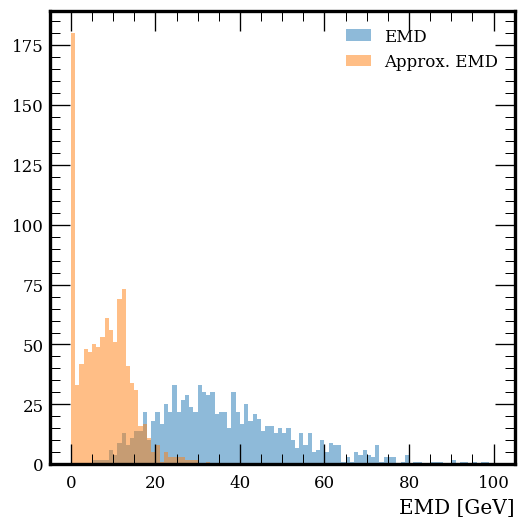

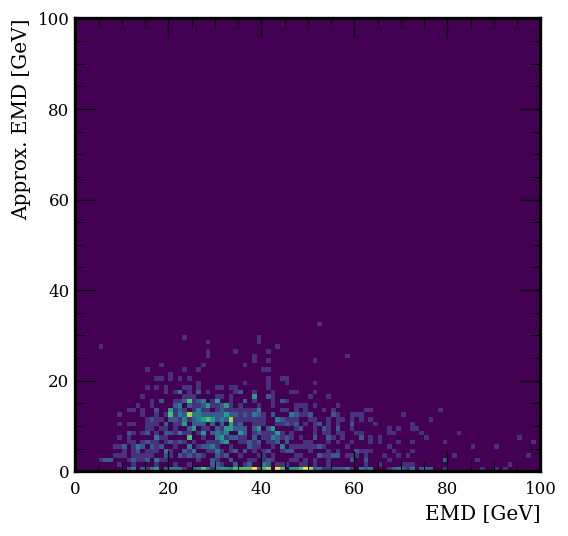

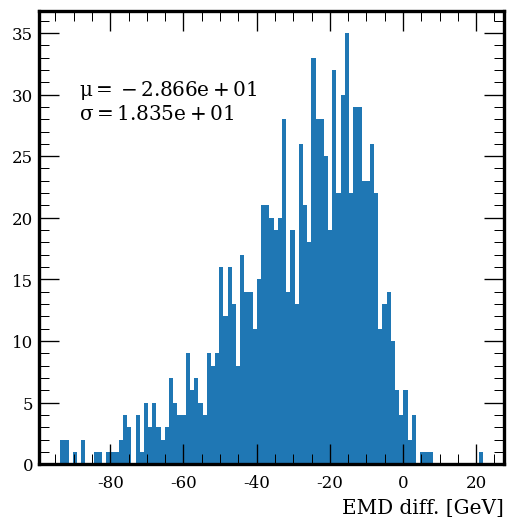

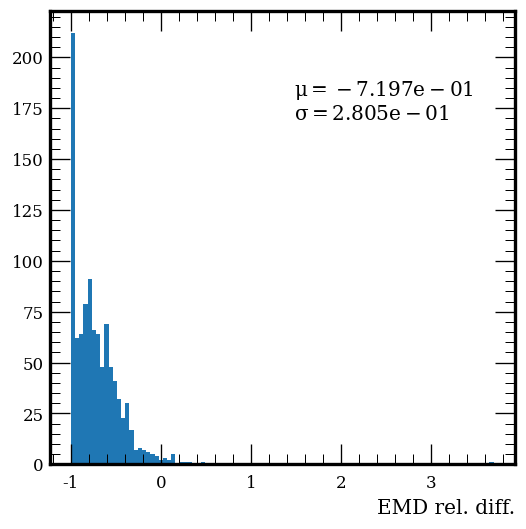

In [76]:
make_plots(losses, emds)

In [38]:
from plot_util import plot_reco_difference, gen_in_out
import mplhep as hep

In [39]:
input_fts, reco_fts = gen_in_out(model, dl, device=device)

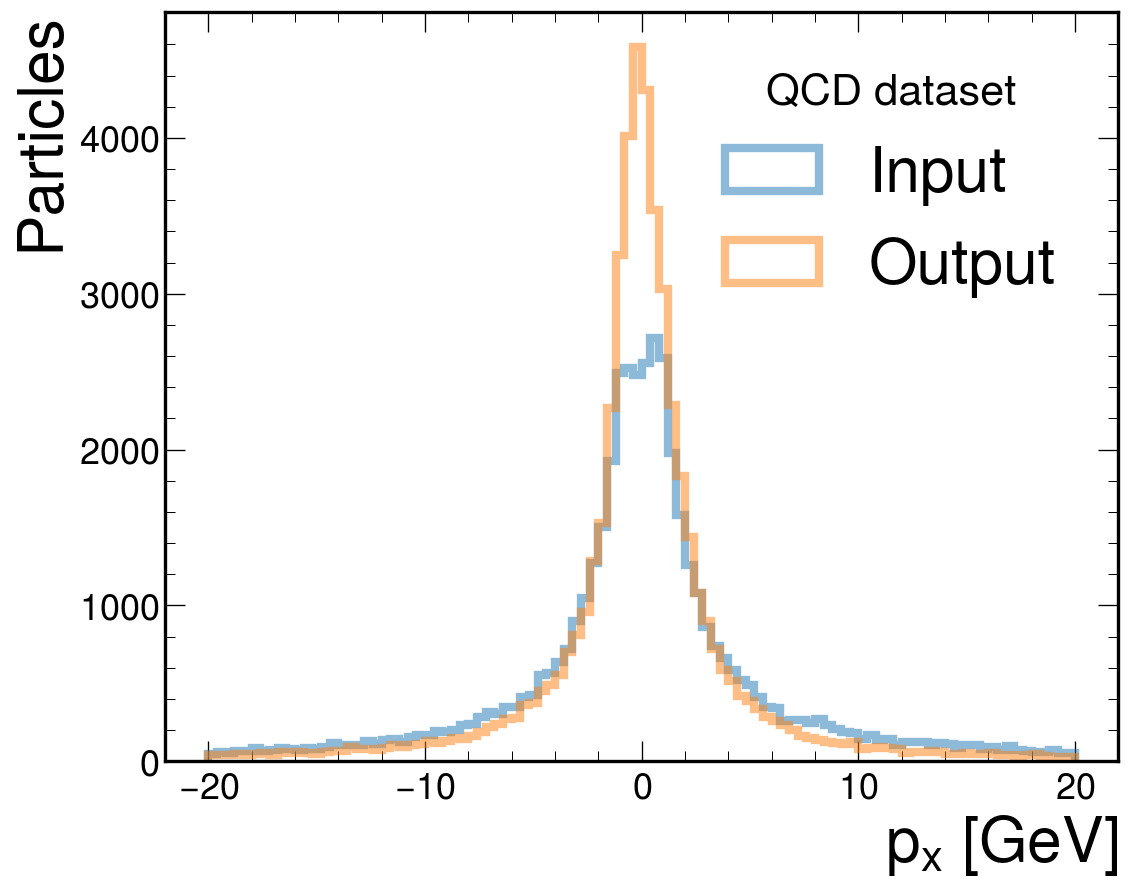

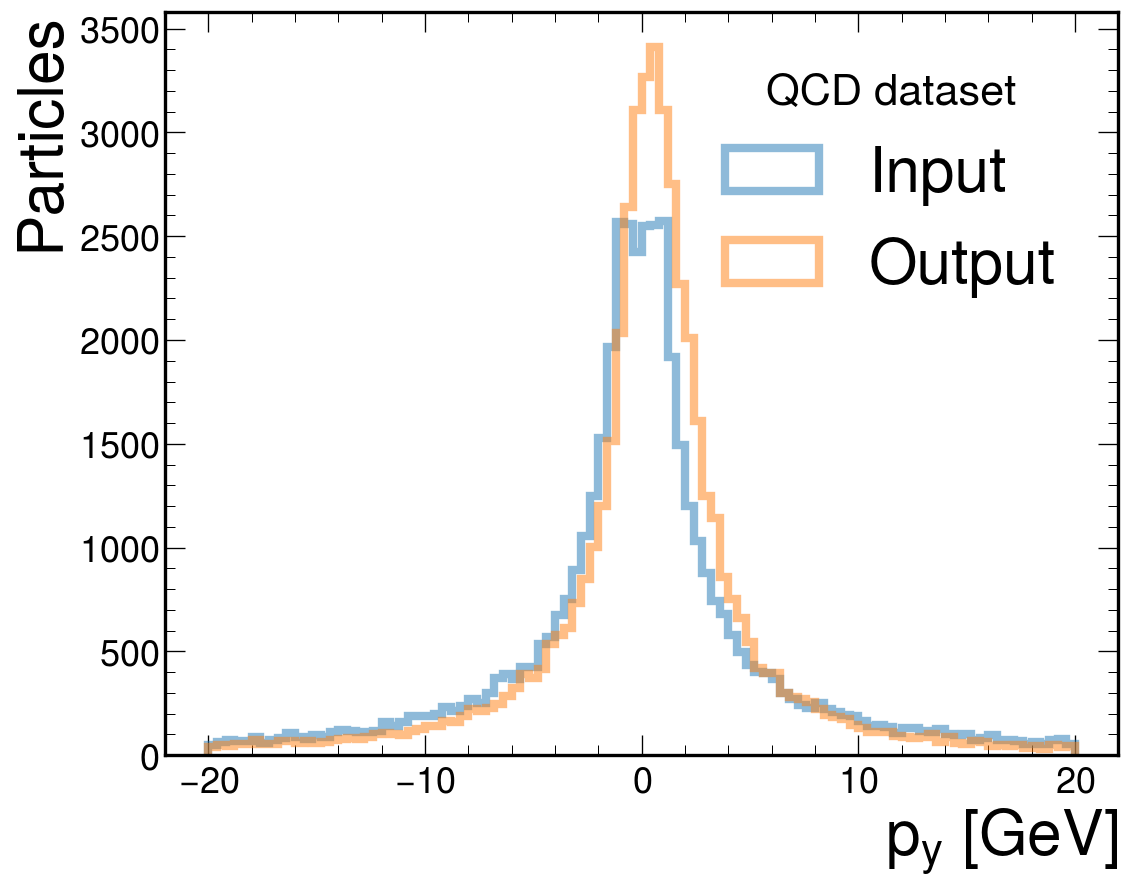

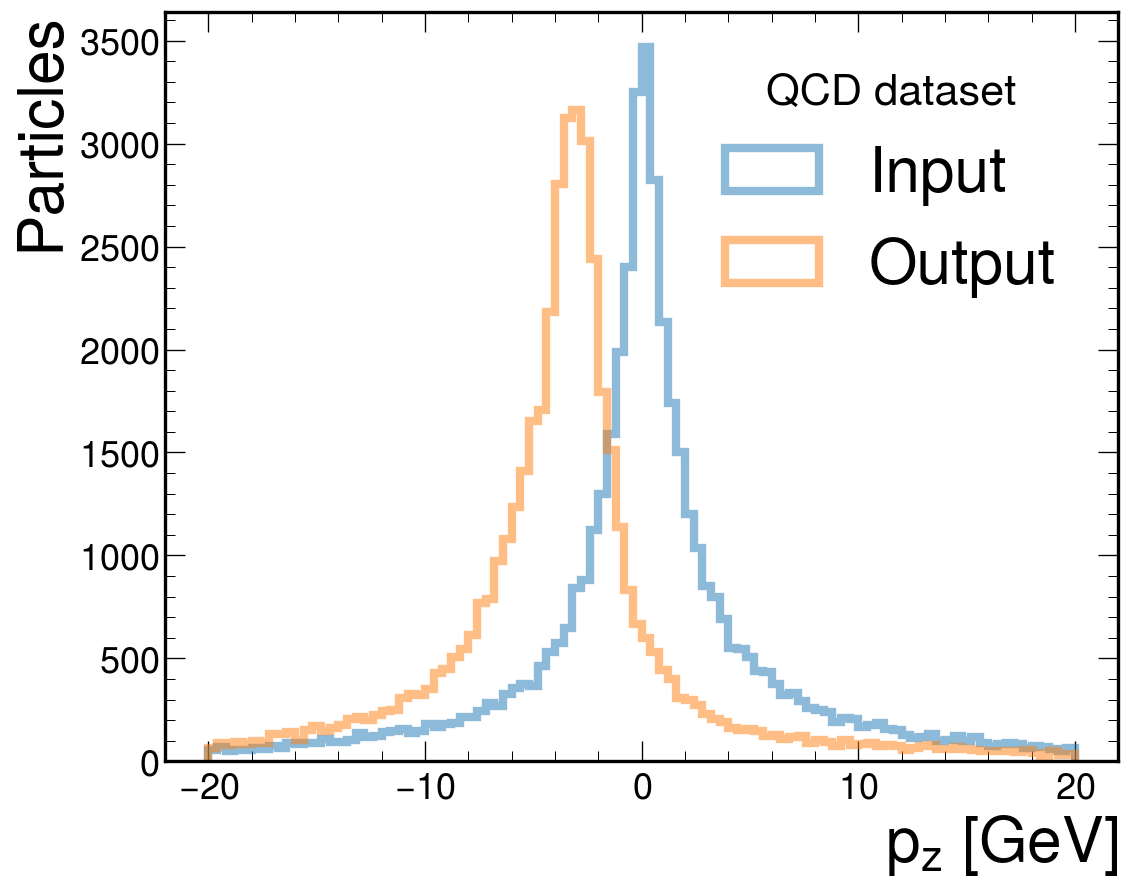

In [40]:
plot_reco_difference(input_fts, reco_fts)